In [1]:
import numpy as np
import pandas as pd
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from config import config
from collections import defaultdict
from matplotlib.ticker import MaxNLocator

def read_mongo(collection, query={}):
    """ Read from Mongo and Store into DataFrame """

    # Make a query to the specific DB and Collection
    cursor = collection.find(query)
    
    elements = []
    for doc in cursor:
        del doc['_id']
        elements.append(doc)
        
    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(elements)
    
    return df

def gerarLinha(repo, modelo, numeroDeIssuesDaRecomendacao):
    return {'projeto': repo, 'modelo': modelo, 'numeroDeIssuesDaRecomendacao': numeroDeIssuesDaRecomendacao, 'numeroDeIssuesTestas': 0, 'nTestes': 0, 'nRecomendacaoDadas': 0, 'totalAcertos': 0, 'totalErros': 0}
    

In [2]:
mongoClient = pymongo.MongoClient(config['DATABASE']['CONNECTION_STRING'])
db = mongoClient[config['DATABASE']['NAME']]

res3 = db['jabref/jabref_results'].find({'tecnica':'sbert', 'topk': 3, 'compare': 'title + body', 'filtros.daysBefore': 30})
res5 = db['jabref/jabref_results'].find({'tecnica':'sbert', 'topk': 5, 'compare': 'title + body', 'filtros.daysBefore': 30})
numbers3 = set(map(lambda x: x['number'], res3))
numbers5 = set(map(lambda x: x['number'], res5))

pd.set_option('display.max_rows', None)

print(numbers3 - numbers5)

{8104, 8513, 8107, 8510}


In [3]:
def getTable(days):
  mongoClient = pymongo.MongoClient(config['DATABASE']['CONNECTION_STRING'])
  db = mongoClient[config['DATABASE']['NAME']]
  table = []
  for col in db.list_collections():
    if not col['name'].endswith('_results'):
      continue
    # projeto (feito)
    # modelo (feito)
    # numeroDeIssuesDaRecomendacao (feito)
    # numeroDeIssuesTestas (feito)
    # nTestes(qnts arquivos corrigidos de verdade) (feito)
    # nRecomendacaoDadas(nTotalDeArquivos)
    # totalAcertos
    # totalErros
    repo = col['name'].replace('_results', '')
    if repo == 'microsoft/vscode':
      continue
    
    linhas = [
      gerarLinha(repo, 'sbert', 1),
      gerarLinha(repo, 'sbert', 3),
      gerarLinha(repo, 'sbert', 5),
      gerarLinha(repo, 'tfidf', 1),
      gerarLinha(repo, 'tfidf', 3),
      gerarLinha(repo, 'tfidf', 5),
      gerarLinha(repo, 'word2vec', 1),
      gerarLinha(repo, 'word2vec', 3),
      gerarLinha(repo, 'word2vec', 5),
      gerarLinha(repo, 'w2vGithub', 1),
      gerarLinha(repo, 'w2vGithub', 3),
      gerarLinha(repo, 'w2vGithub', 5),
    ]

    pos = {
      'sbert': 0,
      'tfidf': 3,
      'word2vec': 6,
      'w2vGithub': 9
    }
    
    results = db[col['name']].find({'compare': 'title + body', 'filtros.daysBefore': days})
    if not db[col['name']].count_documents({'compare': 'title + body', 'filtros.daysBefore': days}):
      continue
    for result in results:
      tecnica = result['tecnica']
      posicao = pos[tecnica]
      if result['topk'] == 3:
        posicao += 1
      if result['topk'] == 5:
        posicao += 2
      
      linhas[posicao]['numeroDeIssuesTestas'] += 1
      linhas[posicao]['nTestes'] += len(result['arquivos_resolvidos_de_verdade'])
      linhas[posicao]['nRecomendacaoDadas'] += len(result['arquivos_sugeridos'])
      linhas[posicao]['totalAcertos'] += result['acertos']
      linhas[posicao]['totalErros'] += result['erros']
    
    table.extend(linhas)
    
  return pd.DataFrame(table)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
table30 = getTable(30)
table90 = getTable(90)
table180 = getTable(180)

In [6]:
projetos = list(set(table30["projeto"]))
projetos.pop(projetos.index('facebook/react-native'))
print(list(set(table30["projeto"])), '\n', list(set(table90["projeto"])), '\n', list(set(table180["projeto"])))

['facebook/react', 'prestodb/presto', 'microsoft/TypeScript', 'neovim/neovim', 'jabref/jabref', 'scikit-learn/scikit-learn', 'facebook/react-native', 'internetarchive/openlibrary', 'tensorflow/tensorflow', 'vuejs/vue'] 
 ['facebook/react', 'prestodb/presto', 'microsoft/TypeScript', 'neovim/neovim', 'jabref/jabref', 'scikit-learn/scikit-learn', 'facebook/react-native', 'internetarchive/openlibrary', 'tensorflow/tensorflow', 'vuejs/vue'] 
 ['facebook/react', 'prestodb/presto', 'microsoft/TypeScript', 'neovim/neovim', 'jabref/jabref', 'scikit-learn/scikit-learn', 'facebook/react-native', 'internetarchive/openlibrary', 'tensorflow/tensorflow', 'vuejs/vue']


# 30 DIAS

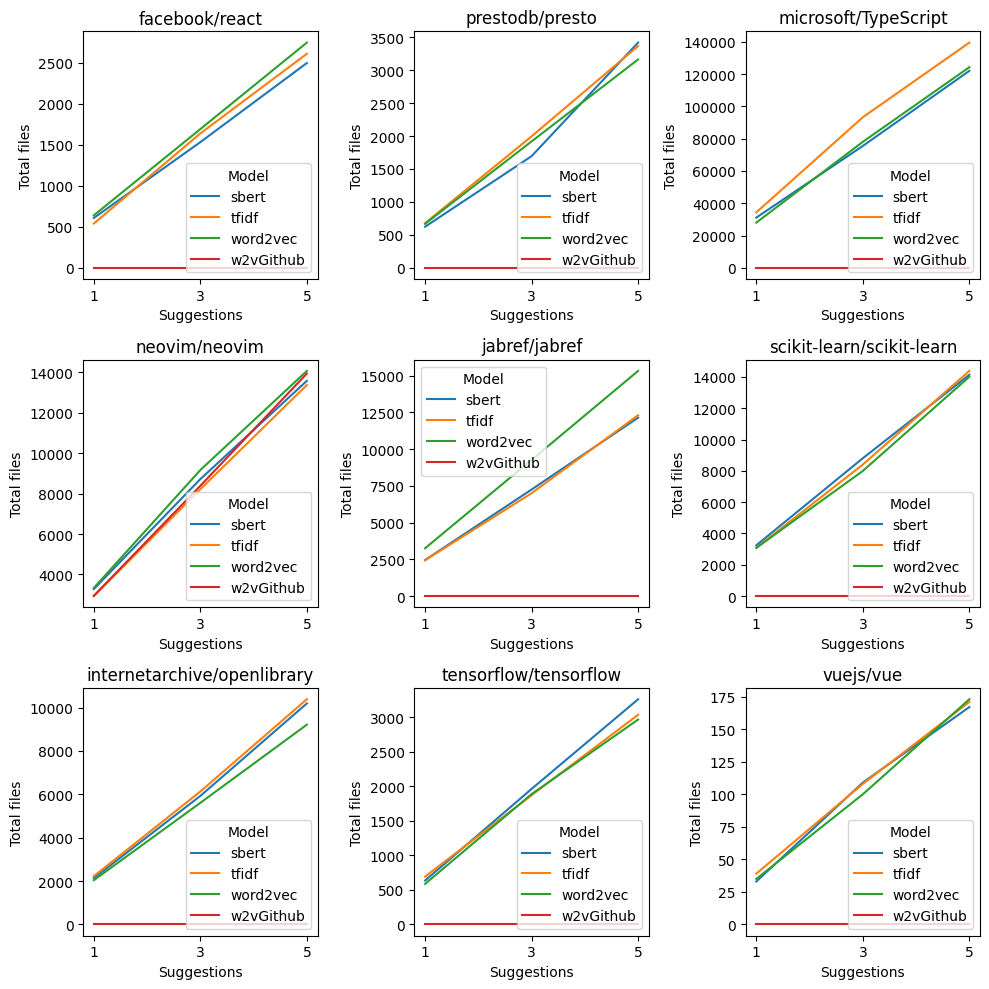

In [7]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, projeto in enumerate(projetos):
  filtered = table30.query(f"projeto == '{projeto}'")
  s = sns.lineplot(ax=axs[i//3,i%3], data=filtered, x="numeroDeIssuesDaRecomendacao", y="nRecomendacaoDadas", hue='modelo')
  s.set_xticks([1, 3, 5])
  s.set(xlabel='Suggestions' ,ylabel='Total files', title=projeto)
  s.legend(title='Model')
fig.tight_layout()

# 90 DIAS

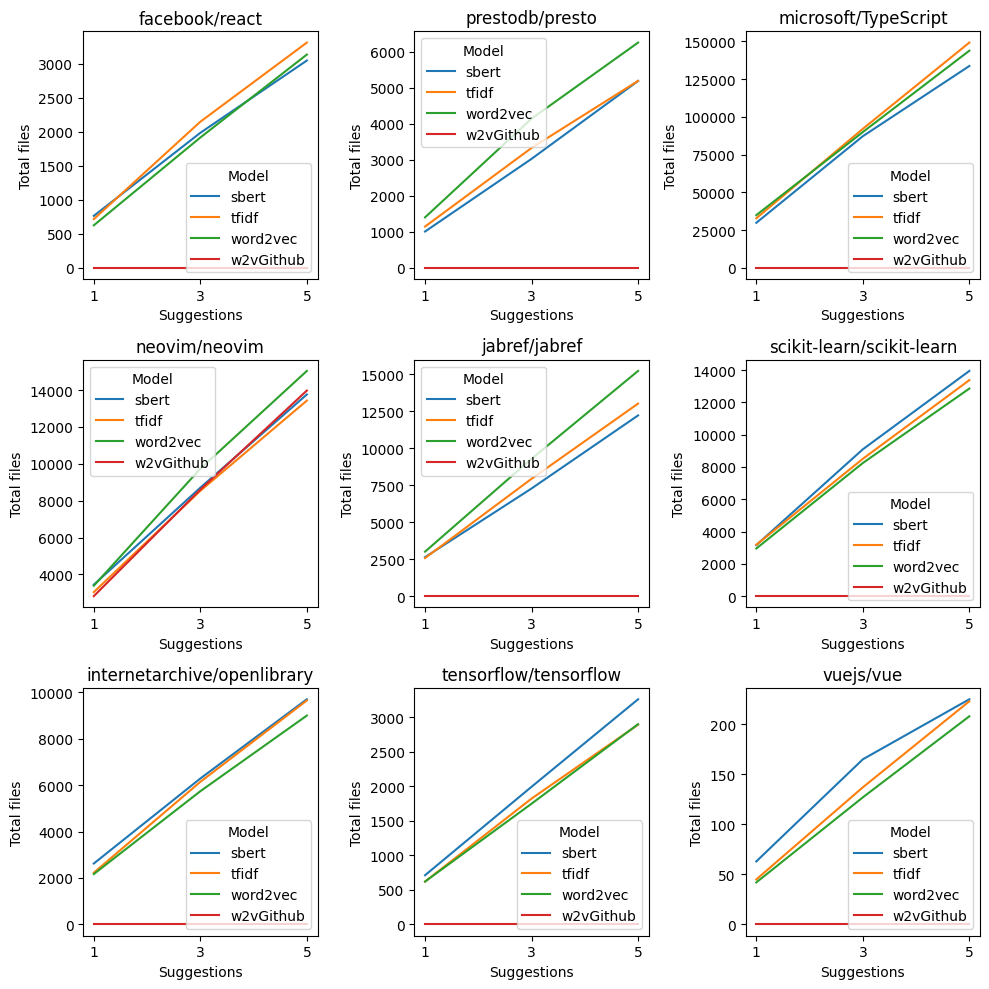

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, projeto in enumerate(projetos):
  filtered = table90.query(f"projeto == '{projeto}'")
  s = sns.lineplot(ax=axs[i//3,i%3], data=filtered, x="numeroDeIssuesDaRecomendacao", y="nRecomendacaoDadas", hue='modelo')
  s.set_xticks([1, 3, 5])
  s.set(xlabel='Suggestions' ,ylabel='Total files', title=projeto)
  s.legend(title='Model')
fig.tight_layout()

# 180 DIAS

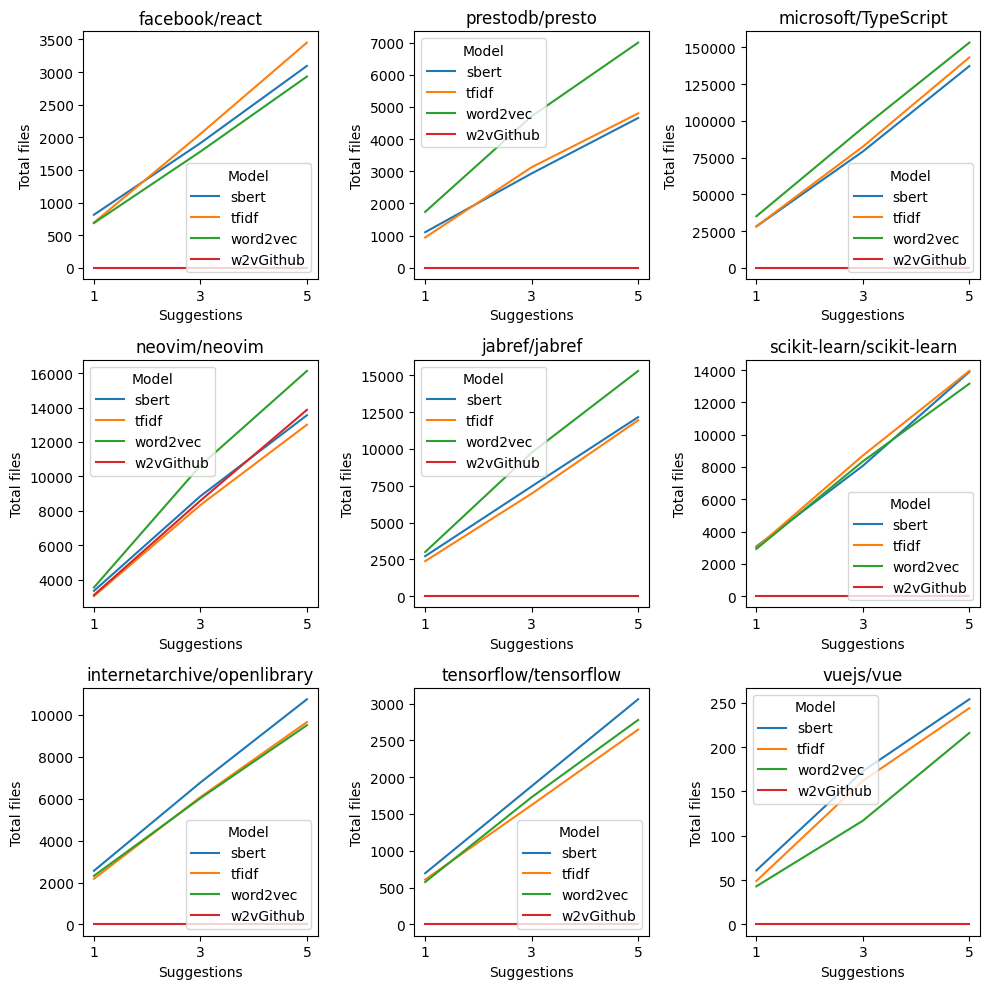

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, projeto in enumerate(projetos):
  filtered = table180.query(f"projeto == '{projeto}'")
  s = sns.lineplot(ax=axs[i//3,i%3], data=filtered, x="numeroDeIssuesDaRecomendacao", y="nRecomendacaoDadas", hue='modelo')
  s.set_xticks([1, 3, 5])
  s.set(xlabel='Suggestions' ,ylabel='Total files', title=projeto)
  s.legend(title='Model')
fig.tight_layout()

# BARRAS PRECISAO

# 1 SUGESTAO

C:\Users\getul\AppData\Local\Temp\ipykernel_21408\2769986897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered30["monthsBefore"] = 1
C:\Users\getul\AppData\Local\Temp\ipykernel_21408\2769986897.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered90["monthsBefore"] = 3
C:\Users\getul\AppData\Local\Temp\ipykernel_21408\2769986897.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

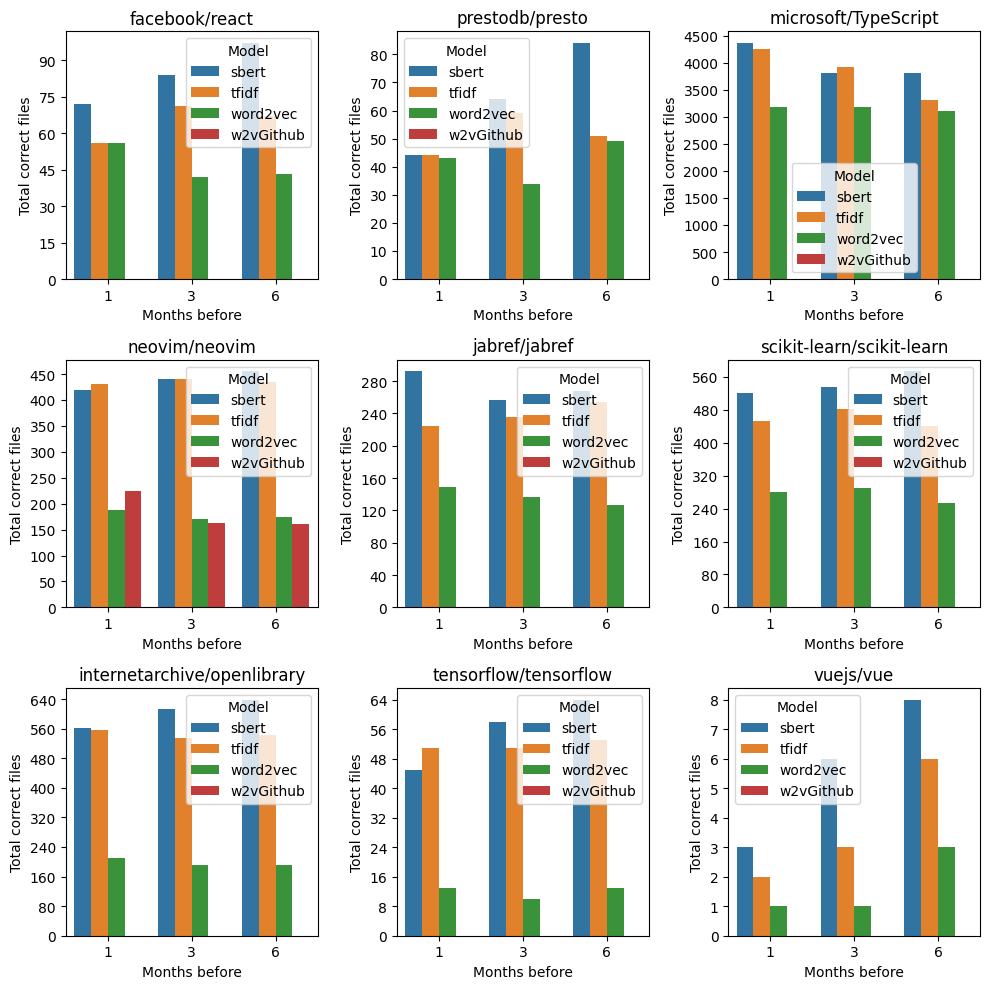

In [10]:
numeroDeIssuesDaRecomendacao = 1

filtered30 = table30.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered30["monthsBefore"] = 1

filtered90 = table90.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered90["monthsBefore"] = 3

filtered180 = table180.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered180["monthsBefore"] = 6

data = pd.concat([filtered30, filtered90, filtered180])

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, projeto in enumerate(projetos):
  filtered = data.query(f"projeto == '{projeto}'")
  s = sns.barplot(ax=axs[i//3,i%3], data=filtered, x="monthsBefore", y="totalAcertos", hue='modelo')
  axs[i//3,i%3].yaxis.set_major_locator(MaxNLocator(integer=True))
  s.set(xlabel='Months before' ,ylabel='Total correct files', title=projeto)
  s.legend(title='Model')
fig.tight_layout()


C:\Users\getul\AppData\Local\Temp\ipykernel_21408\1101362578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered30["monthsBefore"] = 1
C:\Users\getul\AppData\Local\Temp\ipykernel_21408\1101362578.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered90["monthsBefore"] = 3
C:\Users\getul\AppData\Local\Temp\ipykernel_21408\1101362578.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

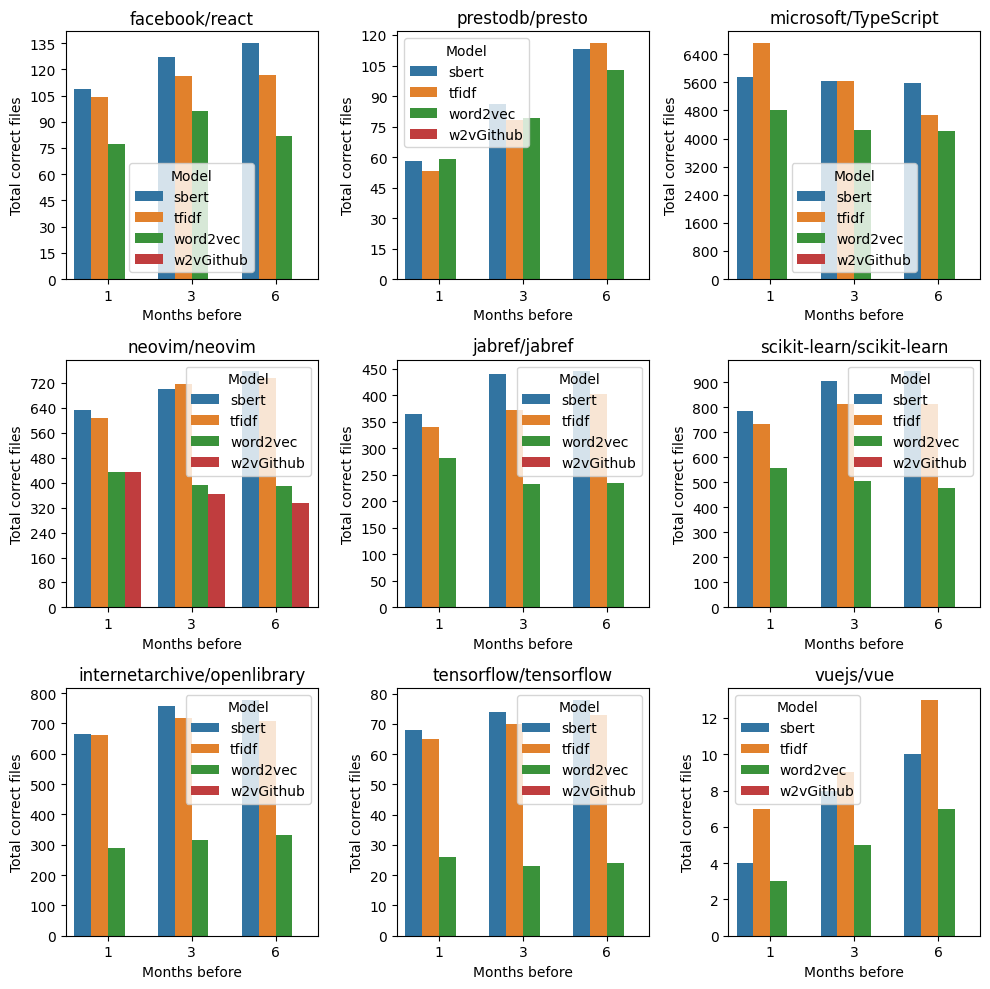

In [11]:
numeroDeIssuesDaRecomendacao = 3

filtered30 = table30.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered30["monthsBefore"] = 1

filtered90 = table90.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered90["monthsBefore"] = 3

filtered180 = table180.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered180["monthsBefore"] = 6

data = pd.concat([filtered30, filtered90, filtered180])

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, projeto in enumerate(projetos):
  filtered = data.query(f"projeto == '{projeto}'")
  s = sns.barplot(ax=axs[i//3,i%3], data=filtered, x="monthsBefore", y="totalAcertos", hue='modelo')
  axs[i//3,i%3].yaxis.set_major_locator(MaxNLocator(integer=True))
  s.set(xlabel='Months before' ,ylabel='Total correct files', title=projeto)
  s.legend(title='Model')
fig.tight_layout()


C:\Users\getul\AppData\Local\Temp\ipykernel_21408\36996869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered30["monthsBefore"] = 1
C:\Users\getul\AppData\Local\Temp\ipykernel_21408\36996869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered90["monthsBefore"] = 3
C:\Users\getul\AppData\Local\Temp\ipykernel_21408\36996869.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

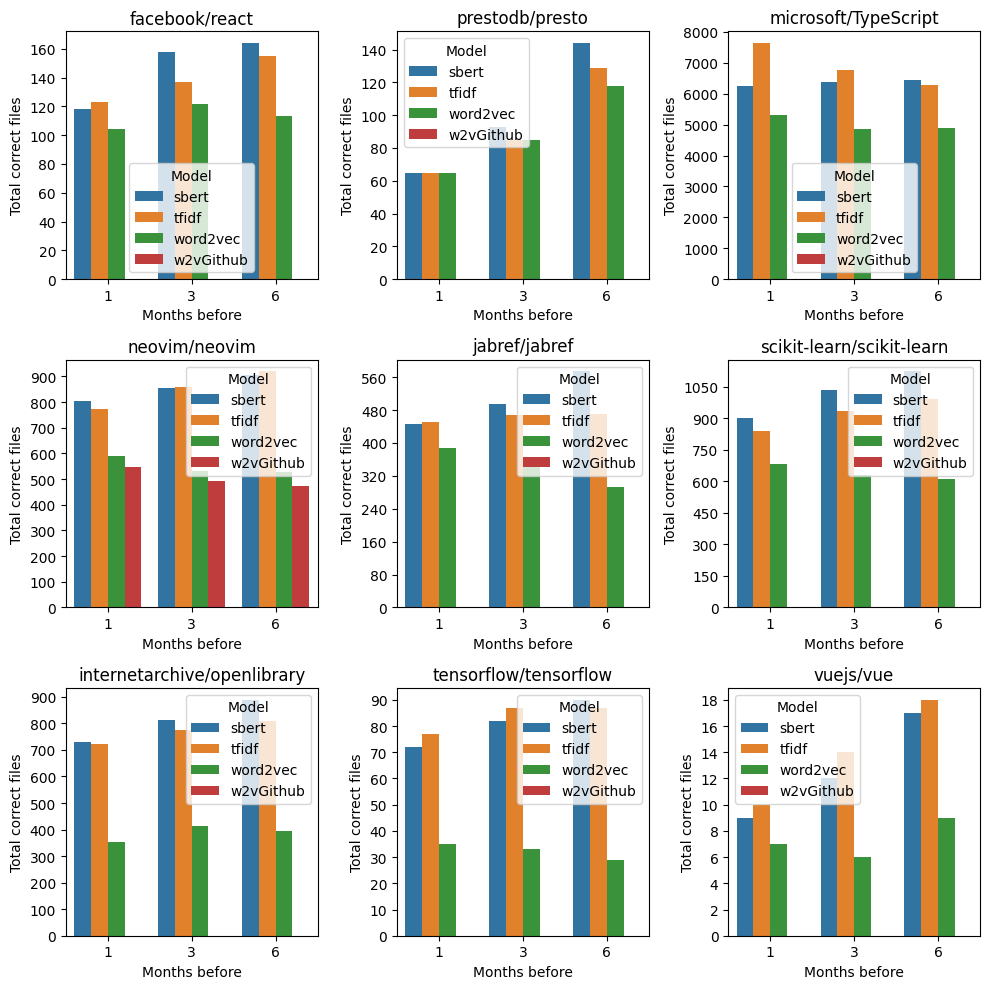

In [12]:
numeroDeIssuesDaRecomendacao = 5

filtered30 = table30.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered30["monthsBefore"] = 1

filtered90 = table90.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered90["monthsBefore"] = 3

filtered180 = table180.query(f"numeroDeIssuesDaRecomendacao == {numeroDeIssuesDaRecomendacao}")
filtered180["monthsBefore"] = 6

data = pd.concat([filtered30, filtered90, filtered180])

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, projeto in enumerate(projetos):
  filtered = data.query(f"projeto == '{projeto}'")
  s = sns.barplot(ax=axs[i//3,i%3], data=filtered, x="monthsBefore", y="totalAcertos", hue='modelo')
  axs[i//3,i%3].yaxis.set_major_locator(MaxNLocator(integer=True))
  s.set(xlabel='Months before' ,ylabel='Total correct files', title=projeto)
  s.legend(title='Model')
fig.tight_layout()


# SIMILARIDADE E PRECISÃO

In [13]:
mongoClient = pymongo.MongoClient(config['DATABASE']['CONNECTION_STRING'])
db = mongoClient[config['DATABASE']['NAME']]

df = []

days = [30, 90, 180]

for col in db.list_collections():
  if not col['name'].endswith('_results'):
    continue
  # projeto (feito)
  # modelo (feito)
  # numeroDeIssuesDaRecomendacao (feito)
  # numeroDeIssuesTestas (feito)
  # nTestes(qnts arquivos corrigidos de verdade) (feito)
  # nRecomendacaoDadas(nTotalDeArquivos)
  # totalAcertos
  # totalErros
  repo = col['name'].replace('_results', '')
  if repo == 'microsoft/vscode':
    continue
  
  results = db[col['name']].find({'topk': 1, 'compare': 'title + body', 'filtros.daysBefore': {'$in': days}})
  if not db[col['name']].count_documents({'topk': 1, 'compare': 'title + body', 'filtros.daysBefore': {'$in': days}}):
    continue
    
  for result in results:
    times = result['acertos']
    for i in range(times):
      df.append(result)

df = pd.DataFrame(df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

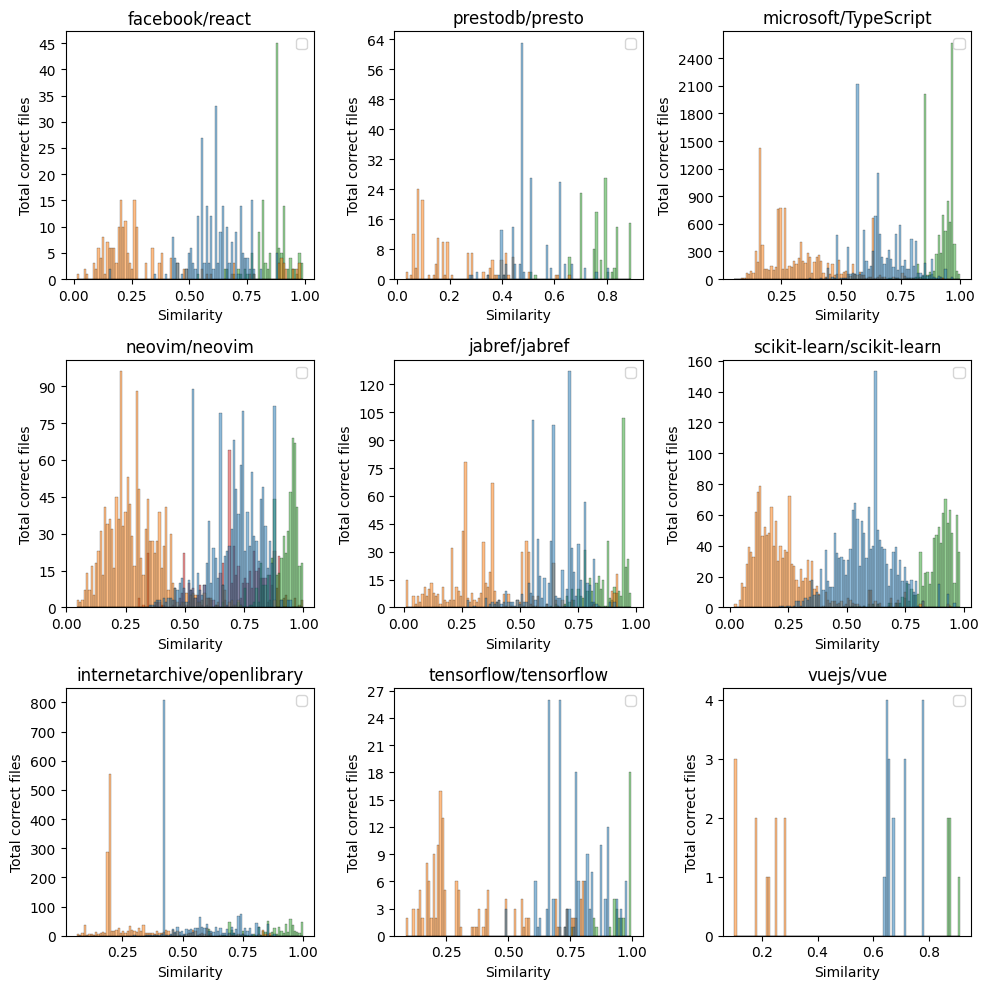

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, projeto in enumerate(projetos):
  filtered = df.query(f"repositorio == '{projeto}'")
  s = sns.histplot(ax=axs[i//3,i%3], data=filtered, x="max_sim", hue='tecnica', hue_order=['sbert', 'tfidf', 'word2vec', 'w2vGithub'], bins=100)
  axs[i//3,i%3].yaxis.set_major_locator(MaxNLocator(integer=True))
  s.set(xlabel='Similarity', ylabel='Total correct files', title=projeto)
  s.legend()
fig.tight_layout()
